In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

## Business Question: What is the best combustible for Cobify to use?

### Exploratory Data Analysis (EDA)

In [2]:
#import data

df=pd.read_csv("measurements.csv")
df.head()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28,5,26,"21,5",12,NaN,E10,0,0,0,45,E10
1,12,"4,2",30,"21,5",13,NaN,E10,0,0,0,NaN,NaN
2,"11,2","5,5",38,"21,5",15,NaN,E10,0,0,0,NaN,NaN
3,"12,9","3,9",36,"21,5",14,NaN,E10,0,0,0,NaN,NaN
4,"18,5","4,5",46,"21,5",15,NaN,E10,0,0,0,NaN,NaN


In [3]:
# webscrapping fuel prices on date 16/08/2023 in Spain

import requests

r = requests.get('https://autotraveler.ru/en/spain/trend-price-fuel-spain.html')   #requesting to webscrap the data.
r.status_code

200

In [4]:
html = r.content   #save it as html doc
soup = BeautifulSoup(html, 'html.parser')

In [5]:
html_table = soup.find_all('table', attrs={'class': 'table table-bordered table-hover'})[0]
fuel_prices = pd.read_html(html_table.prettify())[0]  #using prettify() from Beautiful Soup to make it easier to visualize. 
fuel_prices

# E10 = Super95
# SP98 = Premium 98

,Type of fuel,Now,A week ago,A month ago,A year ago
0,Super 95,€ 1.690,+ € 0.017 1.02 %,+ € 0.094 5.89 %,- € 0.094 5.27 %
1,Premium 98,€ 1.846,+ € 0.019 1.04 %,+ € 0.093 5.31 %,- € 0.094 4.85 %
2,Diesel,€ 1.586,+ € 0.021 1.34 %,+ € 0.136 9.38 %,- € 0.211 11.74 %
3,LPG,€ 0.922,+ € 0.002 0.22 %,+ € 0.010 1.10 %,- € 0.116 11.18 %


In [6]:
# General glimpse of our data

df.shape
print("DataFrame has 388 rows and 12 columns")


DataFrame has 388 rows and 12 columns


In [7]:
#checking datatypes

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   distance       388 non-null    object
 1   consume        388 non-null    object
 2   speed          388 non-null    int64 
 3   temp_inside    376 non-null    object
 4   temp_outside   388 non-null    int64 
 5   specials       93 non-null     object
 6   gas_type       388 non-null    object
 7   AC             388 non-null    int64 
 8   rain           388 non-null    int64 
 9   sun            388 non-null    int64 
 10  refill liters  13 non-null     object
 11  refill gas     13 non-null     object
dtypes: int64(5), object(7)
memory usage: 36.5+ KB


#### Data Cleaning

In [8]:
#converting 'distance', 'consume', 'temp_inside' from object to numerical type since it contains continuous numerical data.

columns_to_convert = ['distance', 'consume', 'temp_inside']
for i in columns_to_convert:
    df[i] = df[i].str.replace(',', '.').astype(float)

In [9]:
# Checking nulls

df.isna().sum()

distance           0
consume            0
speed              0
temp_inside       12
temp_outside       0
specials         295
gas_type           0
AC                 0
rain               0
sun                0
refill liters    375
refill gas       375
dtype: int64

<AxesSubplot:xlabel='temp_inside', ylabel='Density'>

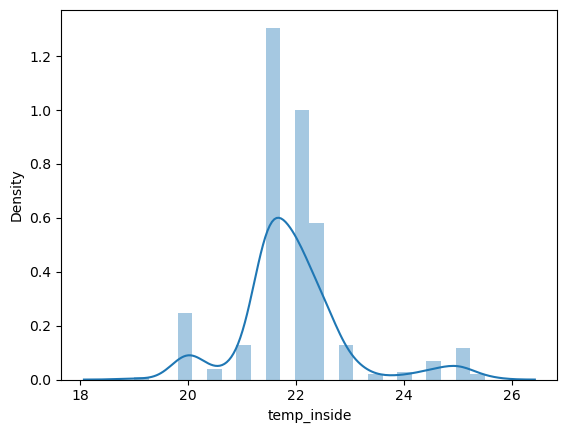

In [10]:
# "temp_inside" column has 12 nulls. Let's check distribution.

sns.distplot(df['temp_inside'])

In [11]:
# Using mean imputation to replace the 12 null values in "temp_inside" column.

mean_temp_inside=df['temp_inside'].mean()
mean_temp_inside = round(mean_temp_inside, 1)
df['temp_inside']=df['temp_inside'].fillna(mean_temp_inside)

In [12]:
#columns 'specials', 'refill liters' and 'refill gas' has more than 70% of missing values. 
nulls_percent = pd.DataFrame(df.isna().sum()*100/len(df)).reset_index() 
nulls_percent.columns = ['column_name', 'nulls_%']
nulls_percent

,column_name,nulls_%
0,distance,0.000000
1,consume,0.000000
2,speed,0.000000
3,temp_inside,0.000000
4,temp_outside,0.000000
5,specials,76.030928
6,gas_type,0.000000
7,AC,0.000000
8,rain,0.000000
9,sun,0.000000


In [13]:
# Dropping columns 'specials', 'refill liters' and 'refill gas' since they have more than 70% of missing values, if we remove the rows we will loose almost all our data.

df.drop(df[['specials', 'refill liters', 'refill gas']], axis = 1, inplace = True)  #axis=1 means dropping columns.

In [14]:
# Add column with total fuel used in each trip

df['total_fuel_L'] = df['distance']*df['consume']/100
df['total_fuel_L'] = df['total_fuel_L'].round(1)

In [15]:
# Add new column with trip_cost

df['cost_trip_€']=np.where(df['gas_type']=='E10', df['total_fuel_L']*1.690, df['total_fuel_L']*1.846).round(1)

In [18]:
#reanming column names

df.rename(columns={'distance':'distance_KM', 'consume':'consume_l/100Km', 'speed':'speed_km/h'}, inplace=True)
df.head()

,distance_KM,consume_l/100Km,speed_km/h,temp_inside,temp_outside,gas_type,AC,rain,sun,total_fuel_L,cost_trip_€
0,28.0,5.0,26,21.5,12,E10,0,0,0,1.4,2.4
1,12.0,4.2,30,21.5,13,E10,0,0,0,0.5,0.8
2,11.2,5.5,38,21.5,15,E10,0,0,0,0.6,1.0
3,12.9,3.9,36,21.5,14,E10,0,0,0,0.5,0.8
4,18.5,4.5,46,21.5,15,E10,0,0,0,0.8,1.4


### Numerical Features Exploration

In [19]:
numerical= df.select_dtypes(np.number)
numerical.describe()

,distance_KM,consume_l/100Km,speed_km/h,temp_inside,temp_outside,AC,rain,sun,total_fuel_L,cost_trip_€
count,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000
mean,19.652835,4.912371,41.927835,21.928608,11.358247,0.077320,0.123711,0.082474,0.935052,1.661598
std,22.667837,1.033172,13.598524,0.994679,6.991542,0.267443,0.329677,0.275441,1.117888,2.007040
min,1.300000,3.300000,14.000000,19.000000,-5.000000,0.000000,0.000000,0.000000,0.100000,0.200000
25%,11.800000,4.300000,32.750000,21.500000,7.000000,0.000000,0.000000,0.000000,0.575000,0.975000
50%,14.600000,4.700000,40.500000,22.000000,10.000000,0.000000,0.000000,0.000000,0.700000,1.250000
75%,19.000000,5.300000,50.000000,22.500000,16.000000,0.000000,0.000000,0.000000,0.900000,1.700000
max,216.100000,12.200000,90.000000,25.500000,31.000000,1.000000,1.000000,1.000000,11.500000,21.200000


- The maximum trip distance is 216 Km with an average distance of around 20 Km per trip.
- Average fuel consumption is around 5 L and an average speed of 40 km/h. 
- Probabily the majority of this company trips are inside cities where speed is controlled and not highways.

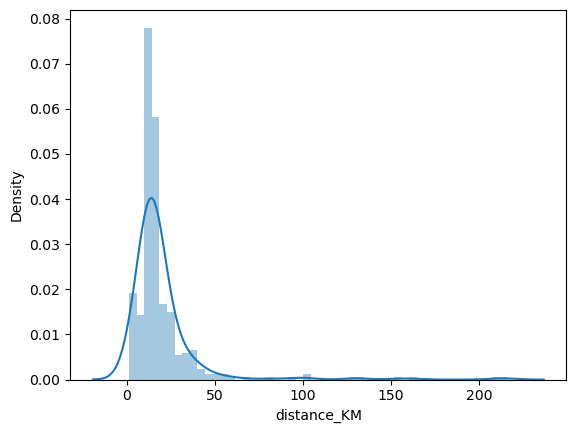

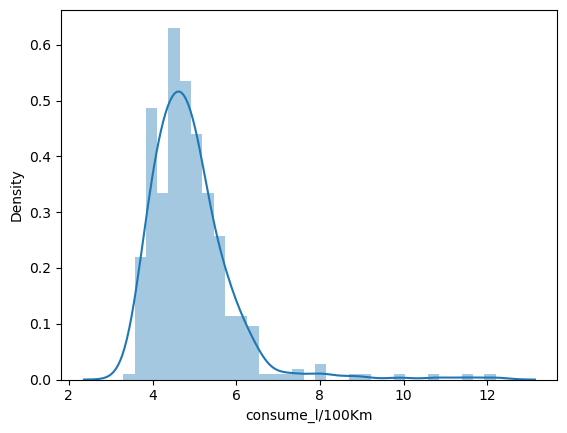

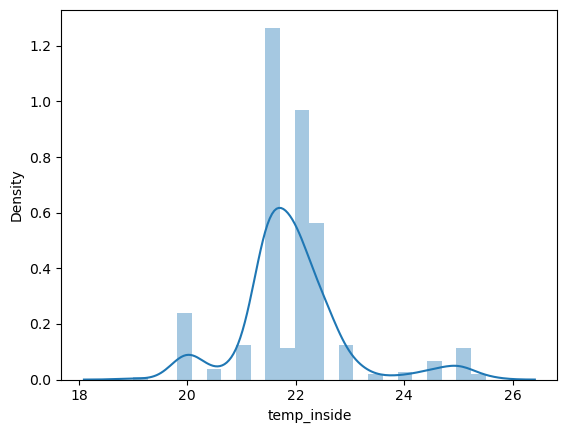

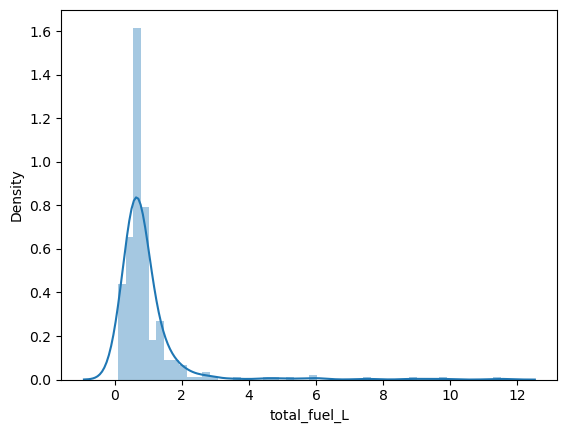

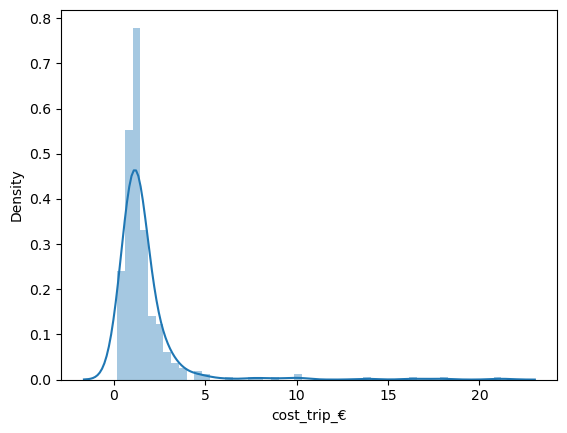

In [22]:
# Visualize distribution of Numerical variables:


continuous = numerical.select_dtypes(float)

for col in continuous.columns:
    sns.distplot(continuous[col])
    plt.show()

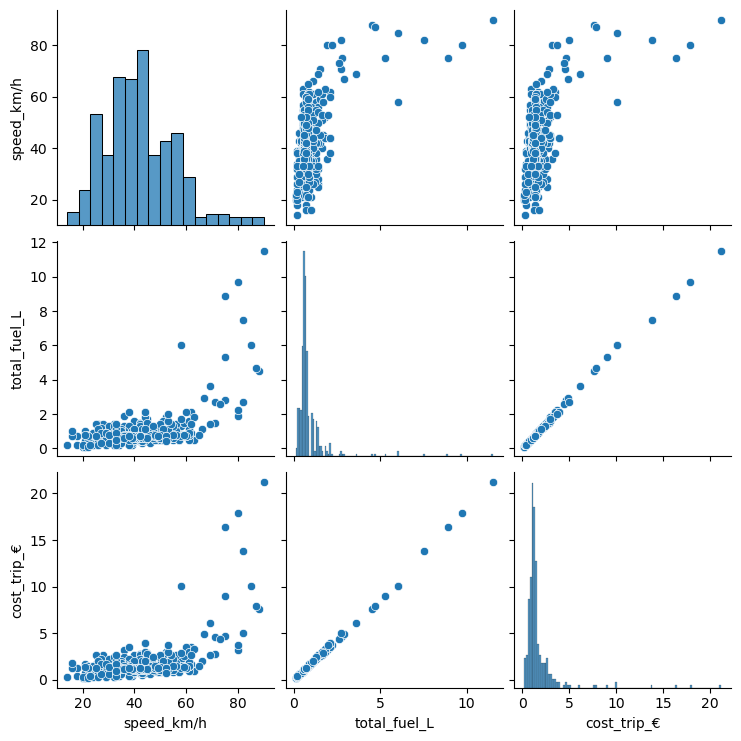

In [26]:
# Let's analyse relationship between some of our numerical variables


trip_data=numerical[['speed_km/h','total_fuel_L','cost_trip_€']]
sns.pairplot(trip_data)

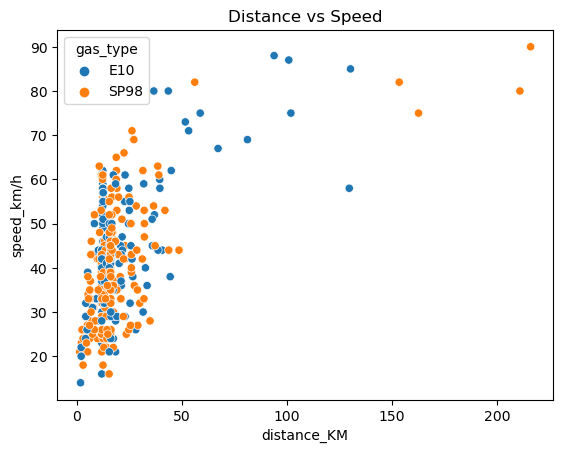

In [29]:
# Distance vs Speed

sns.scatterplot(x='distance_KM', y='speed_km/h', hue='gas_type', data=df)
plt.title("Distance vs Speed")
plt.show()

We can see that **SP98** is the fuel company tends to use for long distance trips (>150KM)

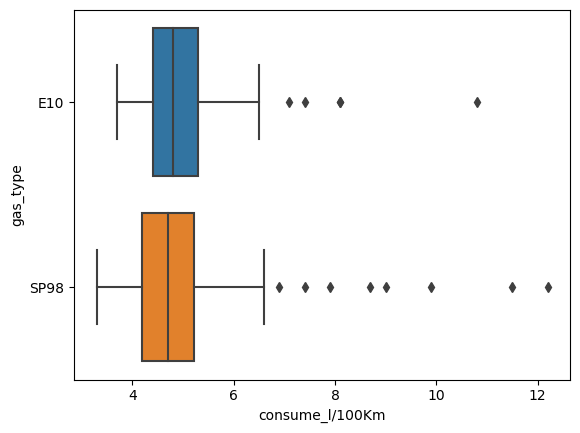

In [32]:
#Let's see which fuel is related with higher consumption rates

sns.boxplot(data=df, x="consume_l/100Km", y="gas_type")
plt.show()

Without analysing any other factors we can see that cars using **SP98** have higher consumption rates.

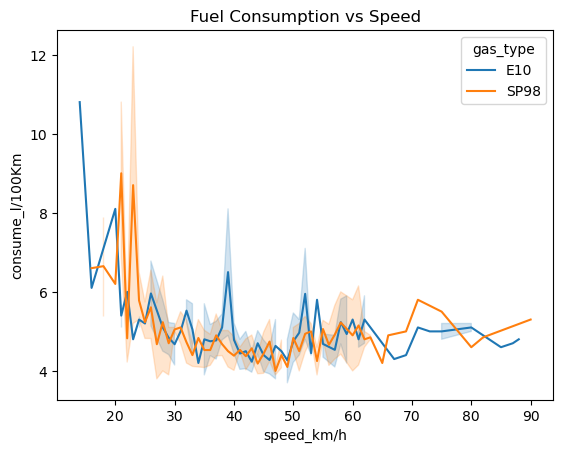

In [42]:
# Let's analyse consumption per gas_type at different speeds.

sns.lineplot(x='speed_km/h', y='consume_l/100Km', hue='gas_type', data=df)
plt.title("Fuel Consumption vs Speed")
plt.show()

We can see fuel consumption is higher when travelling in lower speeds especially with **SP98** fuel. Lower speeds means lower gear which requires more fuel to maintain speed. 

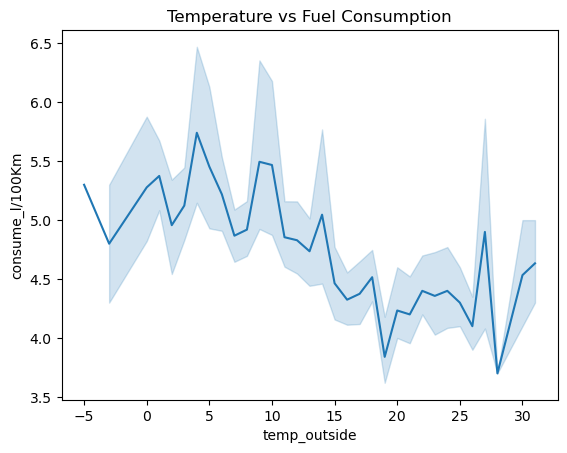

In [36]:
# let's analyse fuel consumption (Fuel Economy) versus temperature outside

sns.lineplot(x='temp_outside', y='consume_l/100Km', data=df)
plt.title("Temperature vs Fuel Consumption")
plt.show()

We can see car fuel economy is better when temperatures are higher outside which is understandable since engine takes less time to warm up!

### Categorical Features Exploration

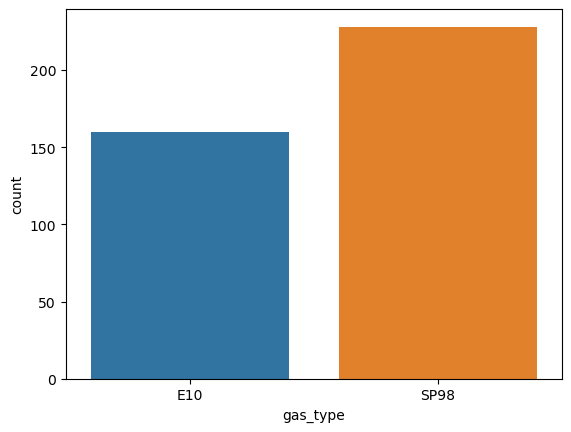

In [37]:
sns.countplot(x ='gas_type', data = df)
plt.show()

- Company is using SP98 more than E10 for their trips.

Text(0.5, 1.0, 'Fuel Consumption Based on Weather Condition: Rain')

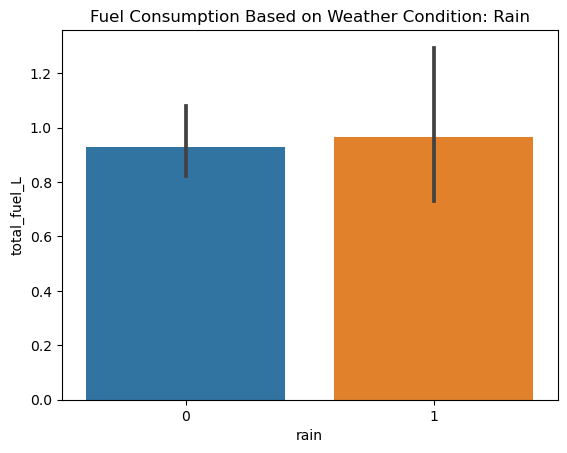

In [38]:
# Let's see if rains has any influence in the amount of fuel used.
sns.barplot(x='rain', y='total_fuel_L', data=df)
plt.title('Fuel Consumption Based on Weather Condition: Rain')

Raining or not does not really affect the amount of fuel used for trips.

Text(0.5, 1.0, 'Fuel Consumption Based on Weather Condition: Sun')

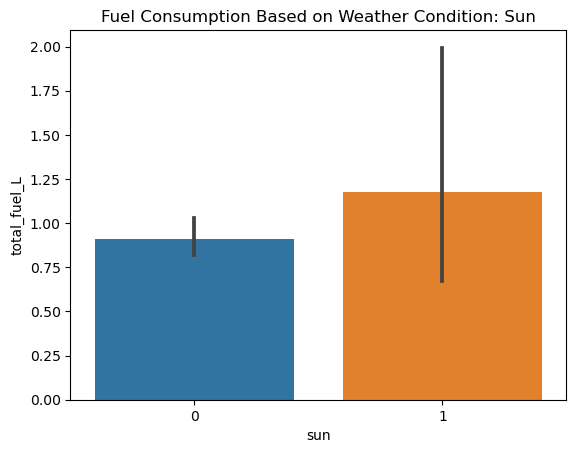

In [39]:
#what about sunny weather?

sns.barplot(x='sun', y='total_fuel_L', data=df)
plt.title('Fuel Consumption Based on Weather Condition: Sun')

However, when it's sunshine it seems the amount of fuel used is higher. Perhaps because when AC is on leads to an increase in the amount of fuel car uses.

In [79]:
fuel_prices

,Type of fuel,Now,A week ago,A month ago,A year ago
0,Super 95,€ 1.690,+ € 0.017 1.02 %,+ € 0.094 5.89 %,- € 0.094 5.27 %
1,Premium 98,€ 1.846,+ € 0.019 1.04 %,+ € 0.093 5.31 %,- € 0.094 4.85 %
2,Diesel,€ 1.586,+ € 0.021 1.34 %,+ € 0.136 9.38 %,- € 0.211 11.74 %
3,LPG,€ 0.922,+ € 0.002 0.22 %,+ € 0.010 1.10 %,- € 0.116 11.18 %


### Answering the question: what is the best combustible for Cobify to use?

Looking at our EDA and fuel_prices table we can say: 

- Being SP98 more expensive than E10(Super95) and being the majority of company trips short distance and at lower speeds, they should really use E10 for this type of trips since fuel economy is better. We can see fuel consumption is higher when travelling at lower speeds especially with SP98, therefore SP98 should be avoided.

- Company should also consider converting some of their cars to **LPG** Fuel cars (gas) since it is a lot cheaper and less polluting and could be used for the long distance trips instead of SP98.

## Fuel Consumption Prediction using a Regression Model

#### Numerical Features Correlation

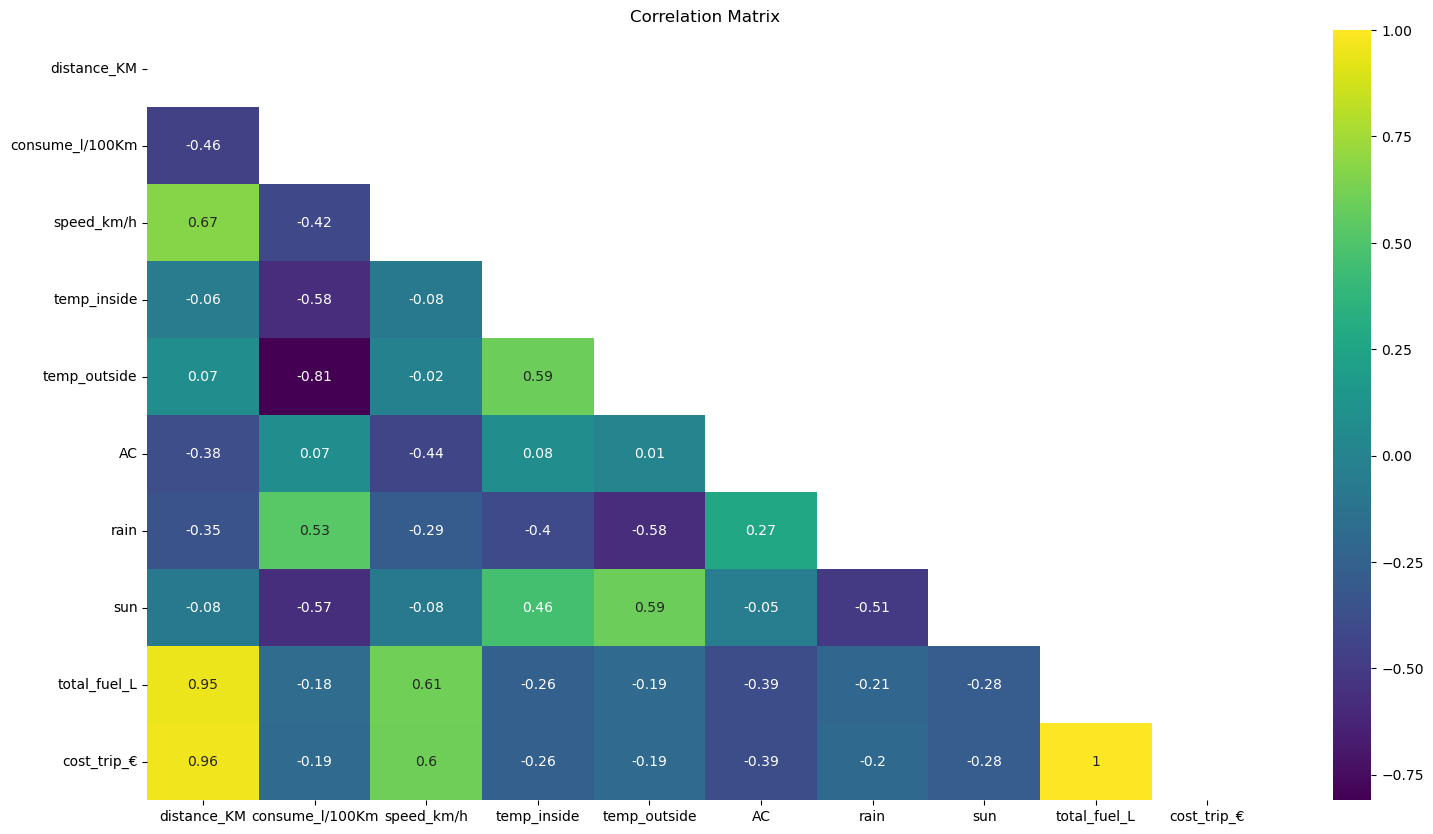

In [43]:
correlations_matrix = df.corr(method='spearman')  #spearman's correlation matrix (Because the relation of the continous numerical variables are not strictly linear and I have ordinal variables as well. 
correlations_matrix=round(correlations_matrix.corr(),2)

mask = np.zeros_like(correlations_matrix)
mask[np.triu_indices_from(mask)] = True
fig, map = plt.subplots(figsize=(18, 10))
map = sns.heatmap(correlations_matrix, mask=mask, annot=True, cmap='viridis')
plt.title('Correlation Matrix')
plt.show()

"cost_trip_€" is highly correlated with "total_fuel_L". Drop the one that is less correlated with our target "consume" -> cost_trip_€.

"total_fuel_L" highly correlated with "distance". Drop "distance".


In [46]:
# Dropping the 2 columns
cols_to_drop=(['cost_trip_€', 'distance_KM'])
df2=df.drop(columns=cols_to_drop)

In [47]:
df.columns

Index(['distance_KM', 'consume_l/100Km', 'speed_km/h', 'temp_inside',
       'temp_outside', 'gas_type', 'AC', 'rain', 'sun', 'total_fuel_L',
       'cost_trip_€'],
      dtype='object')

In [49]:
# X-y Split

X = df.drop(['consume_l/100Km'], axis=1)
y = df['consume_l/100Km']    #target

In [ ]:
#Encode categorical column

X['gas_type'] = np.where(X['gas_type']=='E10', 1, 0)

In [60]:
# Scaling numerical data

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X) #array
X_scaled = pd.DataFrame(X_scaled, columns=X.columns) #array to dataframe

In [69]:
#function to try different models

def different_models(models):
    #train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    model = models
    model.fit(X_train,y_train) 
    
    #predictions

    predictions = model.predict(X_test)
    results = pd.DataFrame()
    results['true'] = y_test
    results['pred'] = predictions
    results['diff'] = results.apply(lambda x: abs(x['true'] - x['pred']), axis=1)
    
    #metrics for evaluation
    r2 = r2_score(y_test, predictions)
    RMSE = mean_squared_error(y_test, predictions, squared=False)
    MSE = mean_squared_error(y_test, predictions)
    MAE = mean_absolute_error(y_test, predictions)
    
    print("The R2 of the model in the test set is: %4.2f" % (r2))
    print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
    print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
    print("The mean absolute error of the model in the test set is: " , MAE)
    
    sns.regplot(results['true'], results['pred'])

The R2 of the model in the test set is: 0.03
The root mean squared error of the model in the test set is:   0.90
The mean squared error of the model in the test set is:   0.81
The mean absolute error of the model in the test set is:  0.5447553373810302


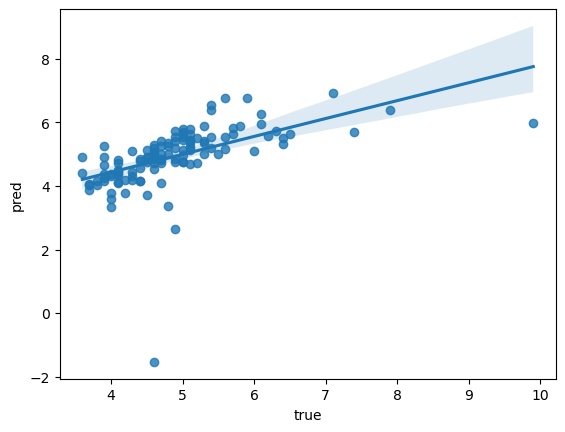

In [70]:
different_models(LinearRegression())

The R2 of the model in the test set is: 0.57
The root mean squared error of the model in the test set is:   0.60
The mean squared error of the model in the test set is:   0.36
The mean absolute error of the model in the test set is:  0.4535897435897436


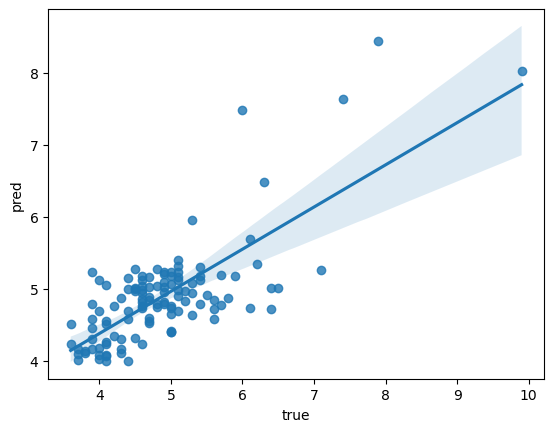

In [72]:
different_models(KNeighborsRegressor(n_neighbors=10))

The R2 of the model in the test set is: 0.69
The root mean squared error of the model in the test set is:   0.51
The mean squared error of the model in the test set is:   0.26
The mean absolute error of the model in the test set is:  0.34599145299145284


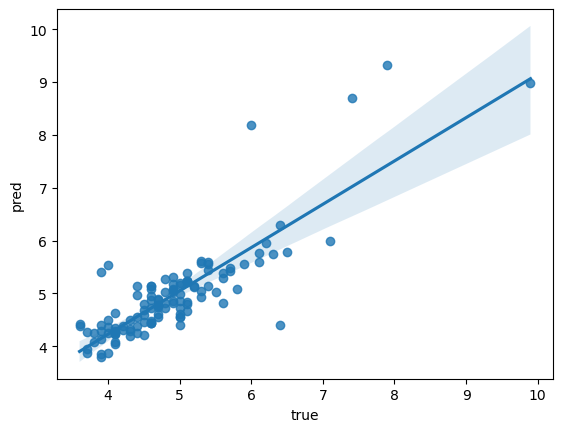

In [74]:
different_models(RandomForestRegressor(n_estimators=100, random_state=42))

The R2 of the model in the test set is: 0.60
The root mean squared error of the model in the test set is:   0.58
The mean squared error of the model in the test set is:   0.34
The mean absolute error of the model in the test set is:  0.35959801918421036


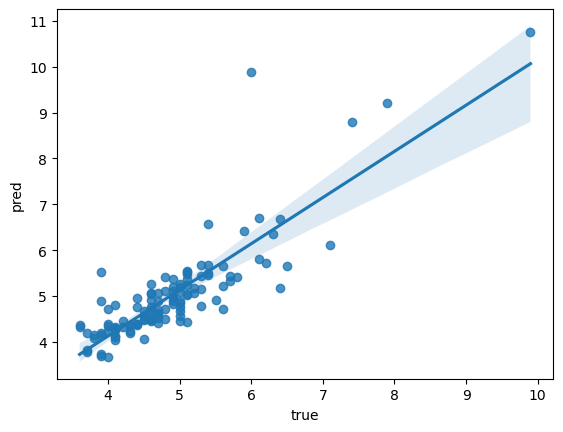

In [78]:
different_models(XGBRegressor())

Conclusion:
   
Our best regression-based machine learning model was the **Random Forest Regressor**, with an R2 of 0.69.

A Random Forest Regression model is a powerful model which performs well with non-linear relationships, don't require feature scaling and can handle outliers automatically.
